In [18]:
# Import library yang diperlukan
import numpy as np
import pandas as pd
from sklearn.ensemble import (RandomForestClassifier, VotingClassifier,
                            BaggingClassifier, AdaBoostClassifier,
                            GradientBoostingRegressor, RandomForestRegressor)
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, mean_squared_error, classification_report
from sklearn.datasets import make_classification, make_regression
import xgboost as xgb

# ===== CONTOH DATA =====
# Membuat dataset contoh untuk klasifikasi
X_class, y_class = make_classification(n_samples=1000, n_features=20,
                                     n_informative=15, n_redundant=5,
                                     random_state=42)
X_train_class, X_test_class, y_train_class, y_test_class = train_test_split(
    X_class, y_class, test_size=0.2, random_state=42)

# Membuat dataset contoh untuk regresi
X_reg, y_reg = make_regression(n_samples=1000, n_features=20,
                              noise=0.1, random_state=42)
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X_reg, y_reg, test_size=0.2, random_state=42)

print("Dataset berhasil dibuat!")
print(f"Klasifikasi - Train: {X_train_class.shape}, Test: {X_test_class.shape}")
print(f"Regresi - Train: {X_train_reg.shape}, Test: {X_test_reg.shape}")
print("="*60)

# ===== 1. VOTING CLASSIFIER =====
print("1. VOTING CLASSIFIER")
print("-" * 30)

# Inisialisasi model individual
log_clf = LogisticRegression(random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
svm_clf = SVC(probability=True, random_state=42)  # probability=True untuk soft voting

# Hard Voting
voting_clf_hard = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='hard'
)
voting_clf_hard.fit(X_train_class, y_train_class)
y_pred_hard = voting_clf_hard.predict(X_test_class)
accuracy_hard = accuracy_score(y_test_class, y_pred_hard)
print(f"Hard Voting Accuracy: {accuracy_hard:.4f}")

# Soft Voting
voting_clf_soft = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='soft'
)
voting_clf_soft.fit(X_train_class, y_train_class)
y_pred_soft = voting_clf_soft.predict(X_test_class)
accuracy_soft = accuracy_score(y_test_class, y_pred_soft)
print(f"Soft Voting Accuracy: {accuracy_soft:.4f}")

# Bandingkan dengan model individual
for clf_name, clf in voting_clf_soft.named_estimators_.items():
    clf.fit(X_train_class, y_train_class)
    y_pred_individual = clf.predict(X_test_class)
    accuracy_individual = accuracy_score(y_test_class, y_pred_individual)
    print(f"{clf_name} Individual Accuracy: {accuracy_individual:.4f}")

print("="*60)

# ===== 2. BAGGING CLASSIFIER =====
print("2. BAGGING CLASSIFIER")
print("-" * 30)

# Bagging dengan Decision Tree
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(random_state=42),
    n_estimators=500,
    max_samples=100,
    bootstrap=True,
    n_jobs=-1,
    random_state=42
)
bag_clf.fit(X_train_class, y_train_class)
y_pred_bag = bag_clf.predict(X_test_class)
accuracy_bag = accuracy_score(y_test_class, y_pred_bag)
print(f"Bagging Classifier Accuracy: {accuracy_bag:.4f}")

# Bandingkan dengan single Decision Tree
single_tree = DecisionTreeClassifier(random_state=42)
single_tree.fit(X_train_class, y_train_class)
y_pred_single = single_tree.predict(X_test_class)
accuracy_single = accuracy_score(y_test_class, y_pred_single)
print(f"Single Decision Tree Accuracy: {accuracy_single:.4f}")
print(f"Improvement: {accuracy_bag - accuracy_single:.4f}")

print("="*60)

# ===== 3. RANDOM FOREST =====
print("3. RANDOM FOREST")
print("-" * 30)

# Random Forest Classifier
rnd_clf = RandomForestClassifier(
    n_estimators=500,
    max_leaf_nodes=16,
    n_jobs=-1,
    random_state=42
)
rnd_clf.fit(X_train_class, y_train_class)
y_pred_rf = rnd_clf.predict(X_test_class)
accuracy_rf = accuracy_score(y_test_class, y_pred_rf)
print(f"Random Forest Accuracy: {accuracy_rf:.4f}")

# Feature importance
feature_importance = rnd_clf.feature_importances_
print("Top 5 Most Important Features:")
for i, importance in enumerate(sorted(enumerate(feature_importance),
                                    key=lambda x: x[1], reverse=True)[:5]):
    print(f"Feature {importance[0]}: {importance[1]:.4f}")

# Extra Trees (Extremely Randomized Trees)
bag_clf_extra = BaggingClassifier(
    DecisionTreeClassifier(splitter="random", max_leaf_nodes=16, random_state=42),
    n_estimators=500,
    max_samples=1.0,
    bootstrap=True,
    n_jobs=-1,
    random_state=42
)
bag_clf_extra.fit(X_train_class, y_train_class)
y_pred_extra = bag_clf_extra.predict(X_test_class)
accuracy_extra = accuracy_score(y_test_class, y_pred_extra)
print(f"Extra Trees Accuracy: {accuracy_extra:.4f}")

print("="*60)

# ===== 4. ADABOOST =====
print("4. ADABOOST")
print("-" * 30)

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1, random_state=42),
    n_estimators=200,
    algorithm="SAMME",
    learning_rate=0.5,
    random_state=42
)
ada_clf.fit(X_train_class, y_train_class)
y_pred_ada = ada_clf.predict(X_test_class)
accuracy_ada = accuracy_score(y_test_class, y_pred_ada)
print(f"AdaBoost Accuracy: {accuracy_ada:.4f}")

print("="*60)

# ===== 5. GRADIENT BOOSTING (Manual Implementation) =====
print("5. GRADIENT BOOSTING - Manual Implementation")
print("-" * 30)

# Manual Gradient Boosting untuk Regresi
def manual_gradient_boosting(X, y, X_new, max_depth=2, n_estimators=3):
    """
    Implementasi manual gradient boosting
    """
    trees = []
    predictions = []

    # First tree
    tree_reg1 = DecisionTreeRegressor(max_depth=max_depth, random_state=42)
    tree_reg1.fit(X, y)
    trees.append(tree_reg1)

    # Residual untuk tree kedua
    y_residual = y - tree_reg1.predict(X)
    tree_reg2 = DecisionTreeRegressor(max_depth=max_depth, random_state=42)
    tree_reg2.fit(X, y_residual)
    trees.append(tree_reg2)

    # Residual untuk tree ketiga
    y_residual2 = y_residual - tree_reg2.predict(X)
    tree_reg3 = DecisionTreeRegressor(max_depth=max_depth, random_state=42)
    tree_reg3.fit(X, y_residual2)
    trees.append(tree_reg3)

    # Prediksi final
    y_pred = sum(tree.predict(X_new) for tree in trees)
    return y_pred, trees

# Test manual implementation
y_pred_manual, manual_trees = manual_gradient_boosting(
    X_train_reg, y_train_reg, X_test_reg)
mse_manual = mean_squared_error(y_test_reg, y_pred_manual)
print(f"Manual Gradient Boosting MSE: {mse_manual:.4f}")

print("="*60)

# ===== 6. GRADIENT BOOSTING (Sklearn) =====
print("6. GRADIENT BOOSTING - Sklearn Implementation")
print("-" * 30)

# Basic Gradient Boosting
gbrt = GradientBoostingRegressor(
    max_depth=2,
    n_estimators=100,
    learning_rate=0.1,
    random_state=42
)
gbrt.fit(X_train_reg, y_train_reg)
y_pred_gbrt = gbrt.predict(X_test_reg)
mse_gbrt = mean_squared_error(y_test_reg, y_pred_gbrt)
print(f"Gradient Boosting MSE: {mse_gbrt:.4f}")

# Gradient Boosting dengan Early Stopping
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train_reg, y_train_reg, test_size=0.2, random_state=42)

gbrt_early = GradientBoostingRegressor(
    max_depth=2,
    n_estimators=200,
    learning_rate=0.1,
    random_state=42
)
gbrt_early.fit(X_train_split, y_train_split)

# Mencari estimator terbaik
errors = [mean_squared_error(y_val_split, y_pred)
          for y_pred in gbrt_early.staged_predict(X_val_split)]
best_n_estimators = np.argmin(errors) + 1

print(f"Best number of estimators: {best_n_estimators}")

# Training ulang dengan estimator terbaik
gbrt_best = GradientBoostingRegressor(
    max_depth=2,
    n_estimators=best_n_estimators,
    learning_rate=0.1,
    random_state=42
)
gbrt_best.fit(X_train_reg, y_train_reg)
y_pred_best = gbrt_best.predict(X_test_reg)
mse_best = mean_squared_error(y_test_reg, y_pred_best)
print(f"Optimized Gradient Boosting MSE: {mse_best:.4f}")

# Early Stopping dengan warm_start
gbrt_warm = GradientBoostingRegressor(
    max_depth=2,
    warm_start=True,
    learning_rate=0.1,
    random_state=42
)

min_val_error = float("inf")
error_going_up = 0
best_estimators_warm = 0

for n_estimators in range(1, 200):
    gbrt_warm.n_estimators = n_estimators
    gbrt_warm.fit(X_train_split, y_train_split)
    y_pred_val = gbrt_warm.predict(X_val_split)
    val_error = mean_squared_error(y_val_split, y_pred_val)

    if val_error < min_val_error:
        min_val_error = val_error
        error_going_up = 0
        best_estimators_warm = n_estimators
    else:
        error_going_up += 1
        if error_going_up == 5:  # early stopping
            break

print(f"Early stopping at {best_estimators_warm} estimators")
print(f"Best validation error: {min_val_error:.4f}")

print("="*60)

# ===== 7. XGBOOST =====
print("7. XGBOOST")
print("-" * 30)

# Basic XGBoost
xgb_reg = xgb.XGBRegressor(random_state=42)
xgb_reg.fit(X_train_reg, y_train_reg)
y_pred_xgb = xgb_reg.predict(X_test_reg)
mse_xgb = mean_squared_error(y_test_reg, y_pred_xgb)
print(f"XGBoost MSE: {mse_xgb:.4f}")

# XGBoost dengan Early Stopping (versi baru)
try:
    # Untuk XGBoost versi baru (>= 1.6.0)
    xgb_reg_early = xgb.XGBRegressor(
        n_estimators=200,
        learning_rate=0.1,
        early_stopping_rounds=10,
        eval_metric='rmse',
        random_state=42
    )
    xgb_reg_early.fit(
        X_train_split, y_train_split,
        eval_set=[(X_val_split, y_val_split)],
        verbose=False
    )
    y_pred_xgb_early = xgb_reg_early.predict(X_test_reg)
    mse_xgb_early = mean_squared_error(y_test_reg, y_pred_xgb_early)
    print(f"XGBoost with Early Stopping MSE: {mse_xgb_early:.4f}")
    try:
        print(f"Best iteration: {xgb_reg_early.best_iteration}")
    except:
        print("Best iteration info not available")

except Exception as e:
    # Fallback untuk XGBoost versi lama
    print(f"XGBoost early stopping error: {e}")
    print("Using basic XGBoost without early stopping...")
    xgb_reg_early = xgb.XGBRegressor(
        n_estimators=100,
        learning_rate=0.1,
        random_state=42
    )
    xgb_reg_early.fit(X_train_split, y_train_split)
    y_pred_xgb_early = xgb_reg_early.predict(X_test_reg)
    mse_xgb_early = mean_squared_error(y_test_reg, y_pred_xgb_early)
    print(f"XGBoost (fallback) MSE: {mse_xgb_early:.4f}")

print("="*60)

# ===== SUMMARY PERBANDINGAN =====
print("SUMMARY - MODEL COMPARISON")
print("-" * 40)
print("CLASSIFICATION MODELS:")
print(f"Hard Voting:        {accuracy_hard:.4f}")
print(f"Soft Voting:        {accuracy_soft:.4f}")
print(f"Bagging:            {accuracy_bag:.4f}")
print(f"Random Forest:      {accuracy_rf:.4f}")
print(f"Extra Trees:        {accuracy_extra:.4f}")
print(f"AdaBoost:           {accuracy_ada:.4f}")
print(f"Single Tree:        {accuracy_single:.4f}")

print("\nREGRESSION MODELS (MSE):")
print(f"Manual Gradient Boosting:    {mse_manual:.4f}")
print(f"Gradient Boosting:           {mse_gbrt:.4f}")
print(f"Optimized Gradient Boosting: {mse_best:.4f}")
print(f"XGBoost:                     {mse_xgb:.4f}")
print(f"XGBoost Early Stopping:      {mse_xgb_early:.4f}")

print("\n" + "="*60)
print("KODE SELESAI - SEMUA MODEL BERHASIL DILATIH!")

Dataset berhasil dibuat!
Klasifikasi - Train: (800, 20), Test: (200, 20)
Regresi - Train: (800, 20), Test: (200, 20)
1. VOTING CLASSIFIER
------------------------------
Hard Voting Accuracy: 0.9100
Soft Voting Accuracy: 0.9100
lr Individual Accuracy: 0.8250
rf Individual Accuracy: 0.9000
svc Individual Accuracy: 0.9350
2. BAGGING CLASSIFIER
------------------------------
Bagging Classifier Accuracy: 0.8750
Single Decision Tree Accuracy: 0.7900
Improvement: 0.0850
3. RANDOM FOREST
------------------------------
Random Forest Accuracy: 0.8700
Top 5 Most Important Features:
Feature 12: 0.1731
Feature 2: 0.0930
Feature 5: 0.0727
Feature 17: 0.0694
Feature 6: 0.0686
Extra Trees Accuracy: 0.8700
4. ADABOOST
------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(


AdaBoost Accuracy: 0.8100
5. GRADIENT BOOSTING - Manual Implementation
------------------------------
Manual Gradient Boosting MSE: 20303.1623
6. GRADIENT BOOSTING - Sklearn Implementation
------------------------------
Gradient Boosting MSE: 3964.4760
Best number of estimators: 200
Optimized Gradient Boosting MSE: 2044.9120
Early stopping at 199 estimators
Best validation error: 2931.7191
7. XGBOOST
------------------------------
XGBoost MSE: 5530.4742
XGBoost with Early Stopping MSE: 5498.4452
Best iteration: 198
SUMMARY - MODEL COMPARISON
----------------------------------------
CLASSIFICATION MODELS:
Hard Voting:        0.9100
Soft Voting:        0.9100
Bagging:            0.8750
Random Forest:      0.8700
Extra Trees:        0.8700
AdaBoost:           0.8100
Single Tree:        0.7900

REGRESSION MODELS (MSE):
Manual Gradient Boosting:    20303.1623
Gradient Boosting:           3964.4760
Optimized Gradient Boosting: 2044.9120
XGBoost:                     5530.4742
XGBoost Early St

Membuat visualisasi perbandingan model...


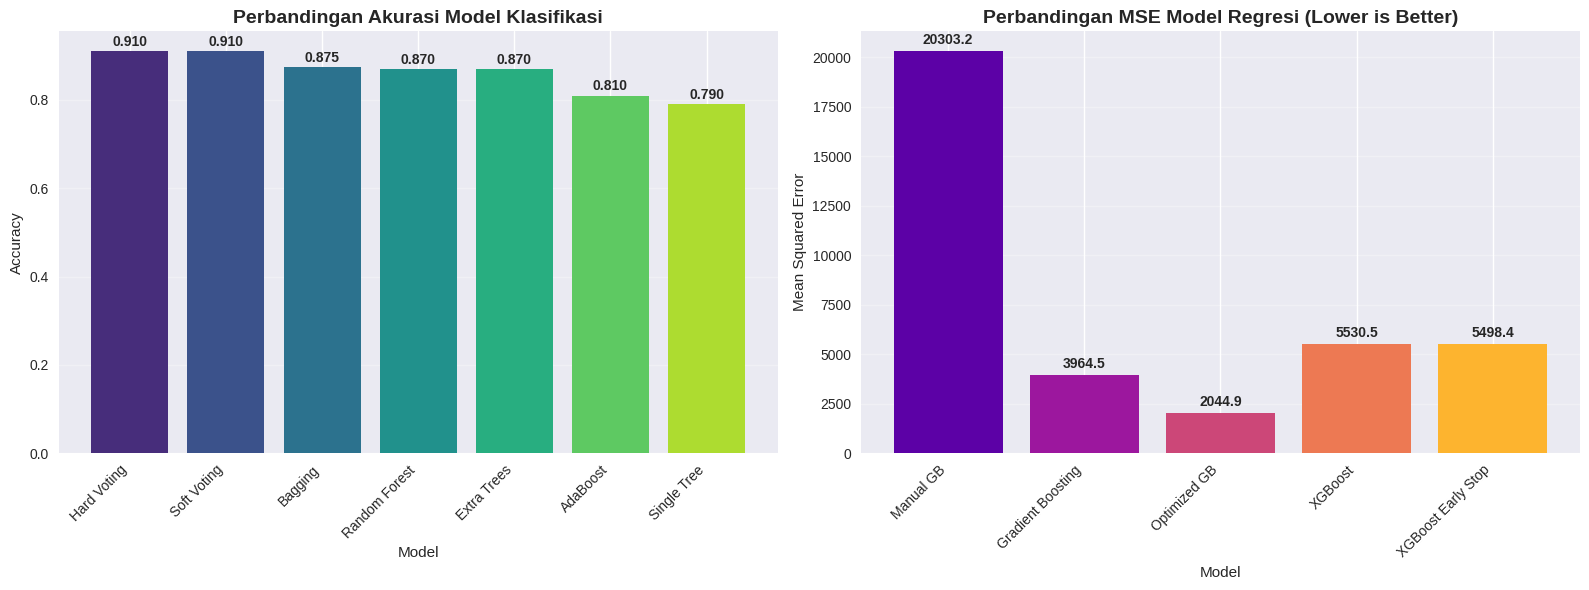

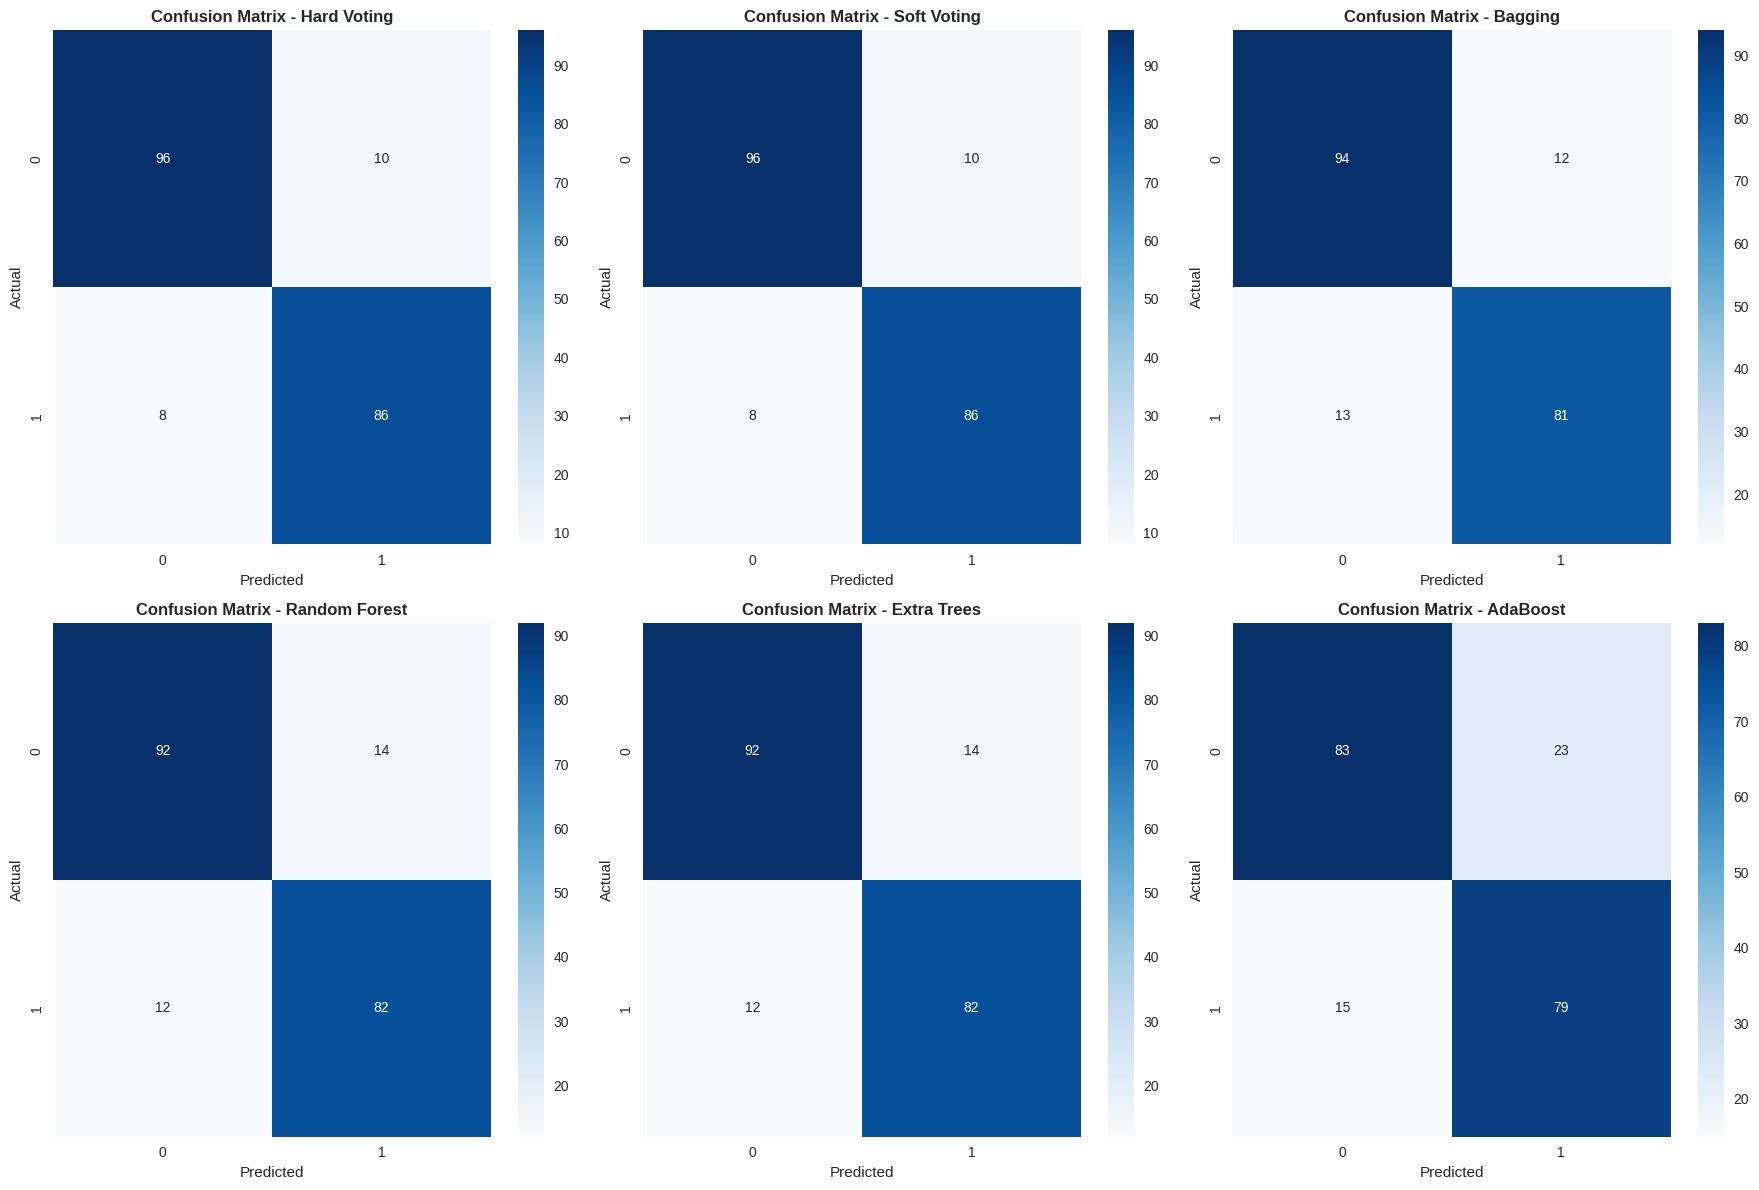

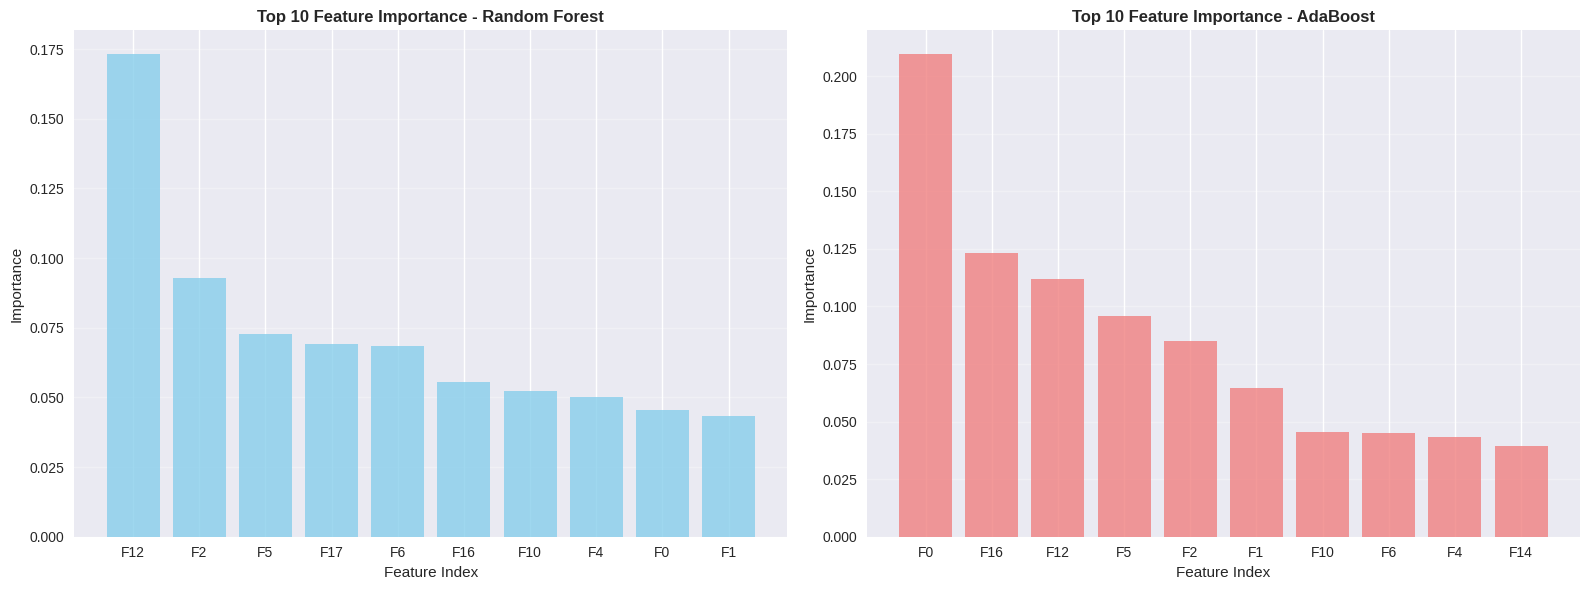

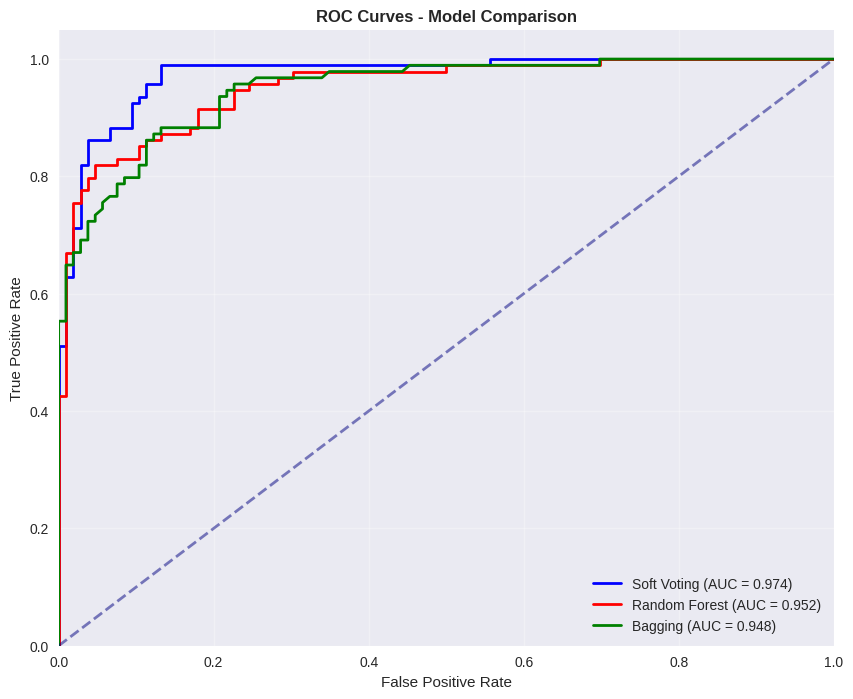

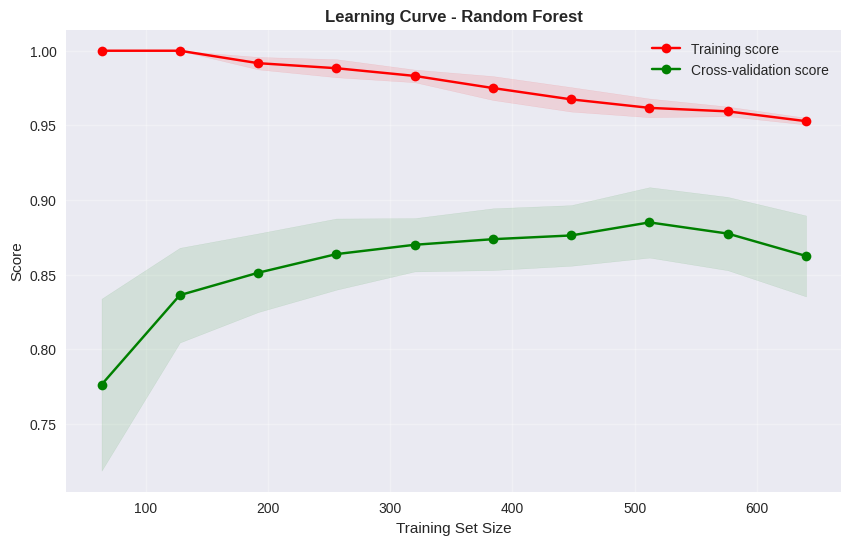

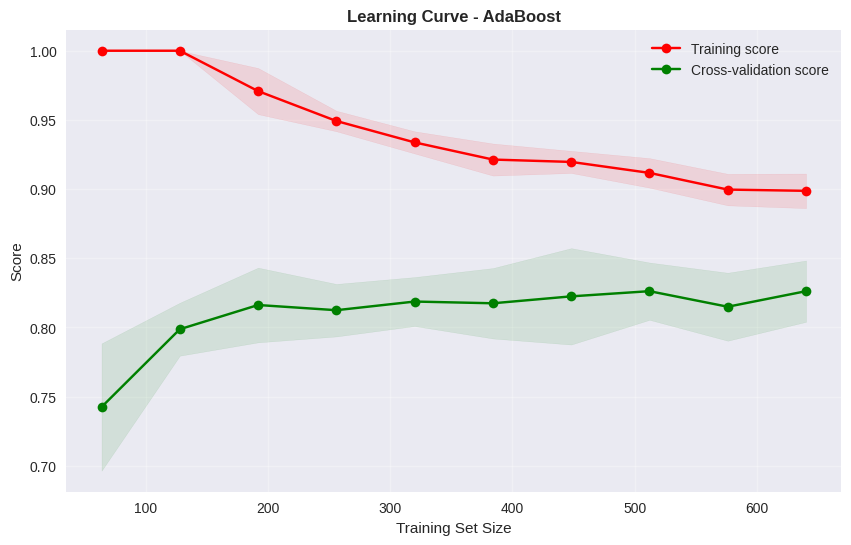

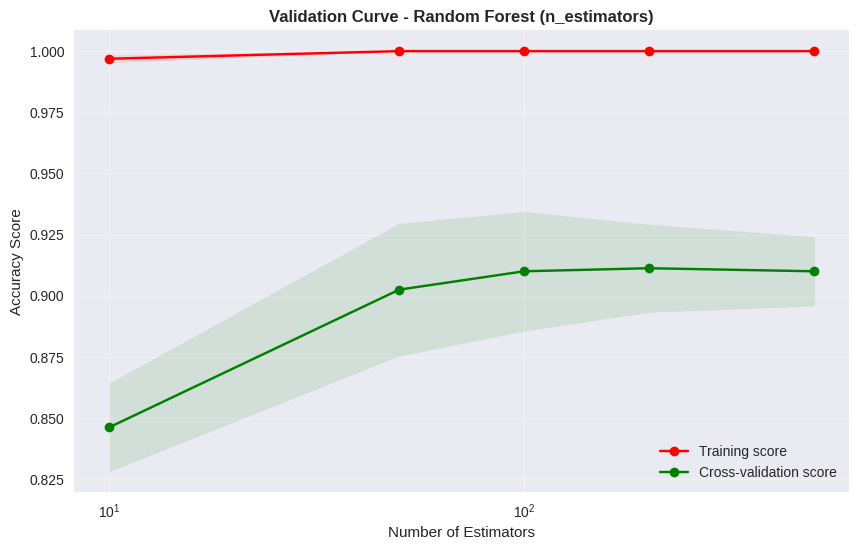

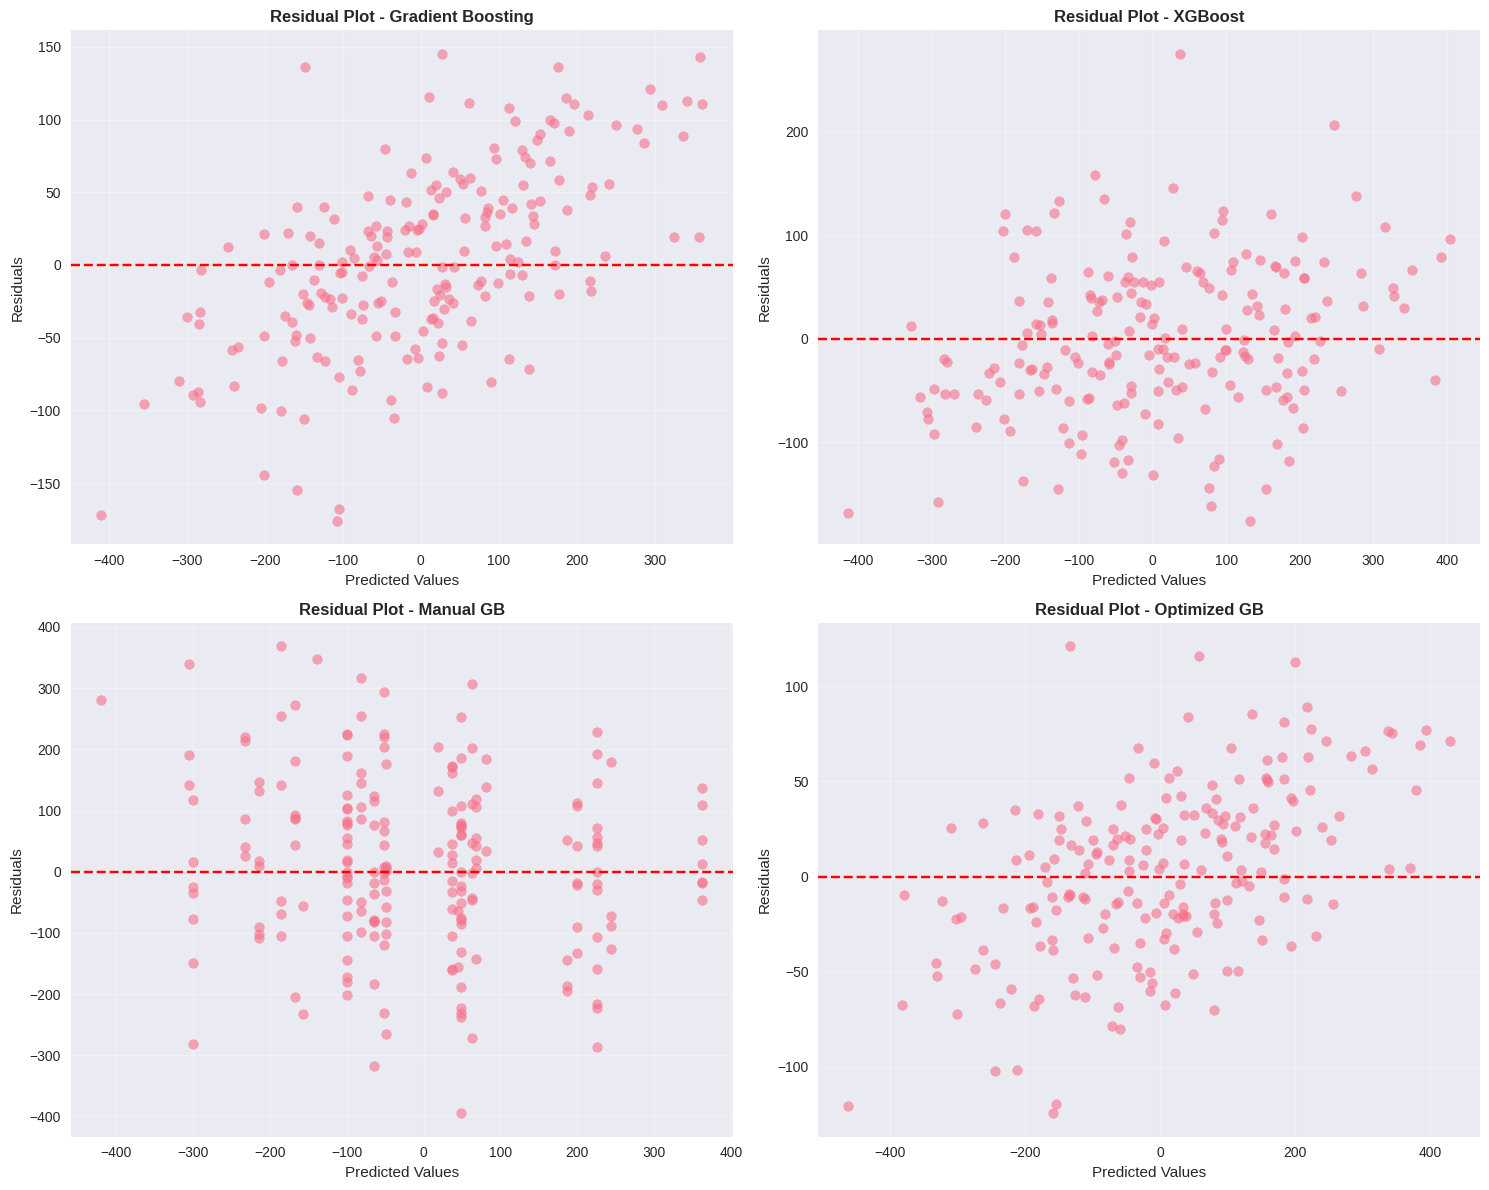

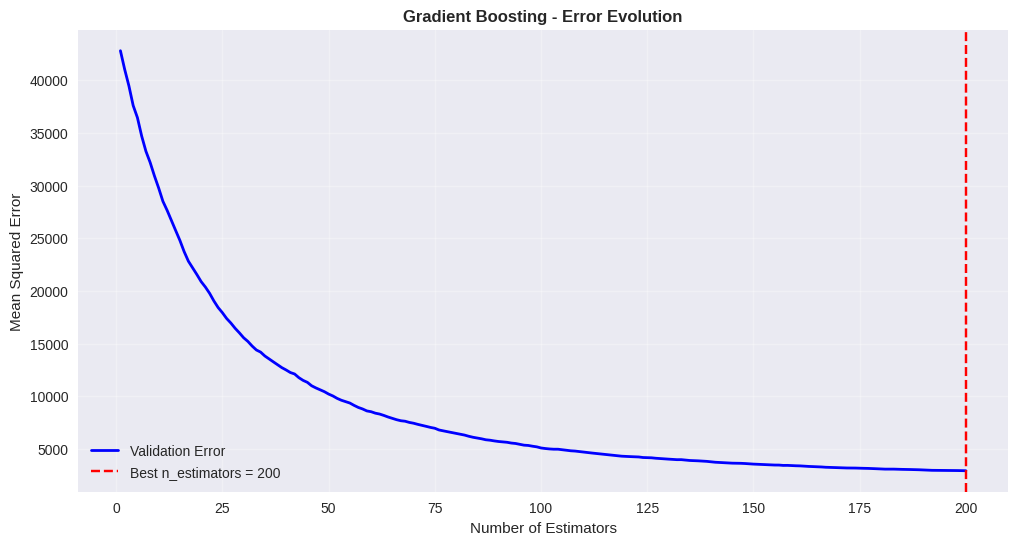

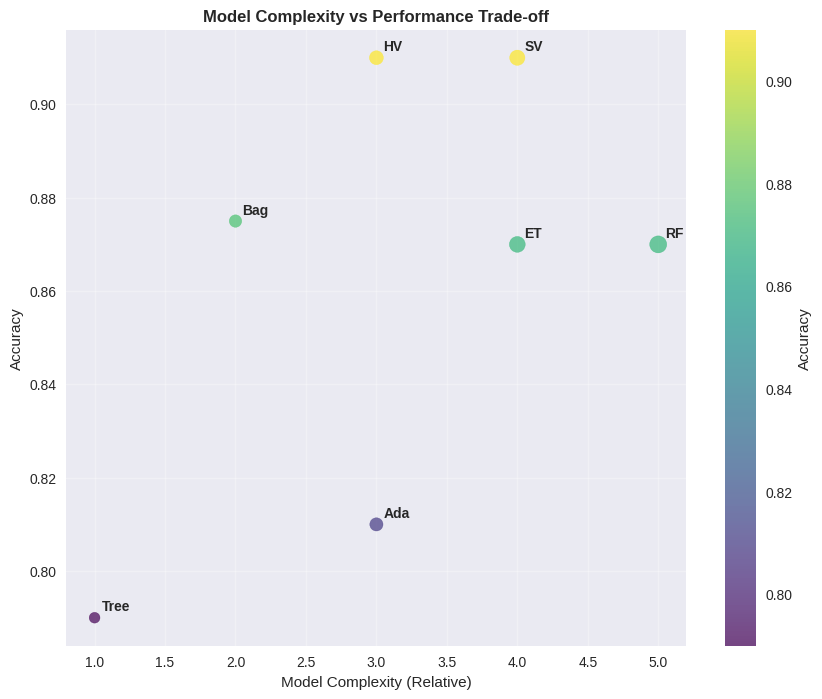


SUMMARY STATISTICS

CLASSIFICATION MODELS RANKING:
        Model  Accuracy  Rank
  Hard Voting    0.9100     1
  Soft Voting    0.9100     2
      Bagging    0.8750     3
Random Forest    0.8700     4
  Extra Trees    0.8700     5
     AdaBoost    0.8100     6
  Single Tree    0.7900     7

REGRESSION MODELS RANKING (Lower MSE is Better):
             Model        MSE  Rank
      Optimized GB  2044.9120     1
 Gradient Boosting  3964.4760     2
XGBoost Early Stop  5498.4452     3
           XGBoost  5530.4742     4
         Manual GB 20303.1623     5

🏆 BEST CLASSIFICATION MODEL: Hard Voting (Accuracy: 0.9100)
🏆 BEST REGRESSION MODEL: Optimized GB (MSE: 2044.9120)

VISUALISASI SELESAI!


In [19]:
# Import library untuk visualisasi
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, roc_curve, auc, mean_squared_error
from sklearn.model_selection import validation_curve, learning_curve
import warnings
warnings.filterwarnings('ignore')

# Set style untuk plot yang lebih menarik
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# ===== 1. PERBANDINGAN AKURASI MODEL KLASIFIKASI =====
print("Membuat visualisasi perbandingan model...")

# Data untuk plotting
classification_models = ['Hard Voting', 'Soft Voting', 'Bagging', 'Random Forest',
                        'Extra Trees', 'AdaBoost', 'Single Tree']
classification_scores = [accuracy_hard, accuracy_soft, accuracy_bag, accuracy_rf,
                        accuracy_extra, accuracy_ada, accuracy_single]

regression_models = ['Manual GB', 'Gradient Boosting', 'Optimized GB', 'XGBoost', 'XGBoost Early Stop']
regression_scores = [mse_manual, mse_gbrt, mse_best, mse_xgb, mse_xgb_early]

# Plot 1: Perbandingan Akurasi Klasifikasi
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Klasifikasi
bars1 = ax1.bar(range(len(classification_models)), classification_scores,
                color=sns.color_palette("viridis", len(classification_models)))
ax1.set_xlabel('Model')
ax1.set_ylabel('Accuracy')
ax1.set_title('Perbandingan Akurasi Model Klasifikasi', fontsize=14, fontweight='bold')
ax1.set_xticks(range(len(classification_models)))
ax1.set_xticklabels(classification_models, rotation=45, ha='right')
ax1.grid(axis='y', alpha=0.3)

# Tambahkan nilai di atas bar
for i, bar in enumerate(bars1):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.005,
             f'{classification_scores[i]:.3f}', ha='center', va='bottom', fontweight='bold')

# Regresi (MSE - lower is better)
bars2 = ax2.bar(range(len(regression_models)), regression_scores,
                color=sns.color_palette("plasma", len(regression_models)))
ax2.set_xlabel('Model')
ax2.set_ylabel('Mean Squared Error')
ax2.set_title('Perbandingan MSE Model Regresi (Lower is Better)', fontsize=14, fontweight='bold')
ax2.set_xticks(range(len(regression_models)))
ax2.set_xticklabels(regression_models, rotation=45, ha='right')
ax2.grid(axis='y', alpha=0.3)

# Tambahkan nilai di atas bar
for i, bar in enumerate(bars2):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + max(regression_scores)*0.01,
             f'{regression_scores[i]:.1f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

# ===== 2. CONFUSION MATRIX UNTUK MODEL TERBAIK =====
# Pilih model klasifikasi terbaik
best_clf_idx = np.argmax(classification_scores[:-1])  # Exclude single tree
best_clf_name = classification_models[best_clf_idx]
best_clf_pred = [y_pred_hard, y_pred_soft, y_pred_bag, y_pred_rf, y_pred_extra, y_pred_ada][best_clf_idx]

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.ravel()

# Confusion matrices untuk beberapa model
models_preds = [
    ('Hard Voting', y_pred_hard),
    ('Soft Voting', y_pred_soft),
    ('Bagging', y_pred_bag),
    ('Random Forest', y_pred_rf),
    ('Extra Trees', y_pred_extra),
    ('AdaBoost', y_pred_ada)
]

for i, (name, pred) in enumerate(models_preds):
    cm = confusion_matrix(y_test_class, pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i])
    axes[i].set_title(f'Confusion Matrix - {name}', fontweight='bold')
    axes[i].set_xlabel('Predicted')
    axes[i].set_ylabel('Actual')

plt.tight_layout()
plt.show()

# ===== 3. FEATURE IMPORTANCE ANALYSIS =====
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Random Forest Feature Importance
feature_importance_rf = rnd_clf.feature_importances_
indices = np.argsort(feature_importance_rf)[::-1][:10]  # Top 10 features

ax1.bar(range(10), feature_importance_rf[indices], color='skyblue', alpha=0.8)
ax1.set_xlabel('Feature Index')
ax1.set_ylabel('Importance')
ax1.set_title('Top 10 Feature Importance - Random Forest', fontweight='bold')
ax1.set_xticks(range(10))
ax1.set_xticklabels([f'F{i}' for i in indices])
ax1.grid(axis='y', alpha=0.3)

# AdaBoost Feature Importance
feature_importance_ada = ada_clf.feature_importances_
indices_ada = np.argsort(feature_importance_ada)[::-1][:10]

ax2.bar(range(10), feature_importance_ada[indices_ada], color='lightcoral', alpha=0.8)
ax2.set_xlabel('Feature Index')
ax2.set_ylabel('Importance')
ax2.set_title('Top 10 Feature Importance - AdaBoost', fontweight='bold')
ax2.set_xticks(range(10))
ax2.set_xticklabels([f'F{i}' for i in indices_ada])
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# ===== 4. ROC CURVES =====
fig, ax = plt.subplots(figsize=(10, 8))

# ROC untuk model yang mendukung predict_proba
models_roc = [
    ('Soft Voting', voting_clf_soft),
    ('Random Forest', rnd_clf),
    ('Bagging', bag_clf)
]

colors = ['blue', 'red', 'green']
for i, (name, model) in enumerate(models_roc):
    try:
        y_proba = model.predict_proba(X_test_class)[:, 1]
        fpr, tpr, _ = roc_curve(y_test_class, y_proba)
        roc_auc = auc(fpr, tpr)
        ax.plot(fpr, tpr, color=colors[i], lw=2,
                label=f'{name} (AUC = {roc_auc:.3f})')
    except:
        print(f"ROC curve tidak tersedia untuk {name}")

ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', alpha=0.5)
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curves - Model Comparison', fontweight='bold')
ax.legend(loc="lower right")
ax.grid(alpha=0.3)
plt.show()

# ===== 5. LEARNING CURVES =====
def plot_learning_curve(estimator, title, X, y, cv=5, n_jobs=-1,
                        train_sizes=np.linspace(.1, 1.0, 10)):
    fig, ax = plt.subplots(figsize=(10, 6))

    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes,
        scoring='accuracy' if hasattr(y, 'max') and y.max() < 10 else 'neg_mean_squared_error')

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    ax.fill_between(train_sizes, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax.fill_between(train_sizes, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    ax.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

    ax.set_xlabel('Training Set Size')
    ax.set_ylabel('Score')
    ax.set_title(f'Learning Curve - {title}', fontweight='bold')
    ax.legend(loc="best")
    ax.grid(alpha=0.3)

    return fig

# Learning curves untuk beberapa model
models_lc = [
    ('Random Forest', rnd_clf),
    ('AdaBoost', ada_clf)
]

for name, model in models_lc:
    try:
        plot_learning_curve(model, name, X_train_class, y_train_class)
        plt.show()
    except Exception as e:
        print(f"Learning curve error untuk {name}: {e}")

# ===== 6. VALIDATION CURVES =====
# Validation curve untuk Random Forest (n_estimators)
param_range = [10, 50, 100, 200, 500]
train_scores, test_scores = validation_curve(
    RandomForestClassifier(random_state=42), X_train_class, y_train_class,
    param_name='n_estimators', param_range=param_range,
    cv=5, scoring='accuracy', n_jobs=-1)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

fig, ax = plt.subplots(figsize=(10, 6))
ax.semilogx(param_range, train_scores_mean, 'o-', color='r', label='Training score')
ax.fill_between(param_range, train_scores_mean - train_scores_std,
                train_scores_mean + train_scores_std, alpha=0.1, color='r')
ax.semilogx(param_range, test_scores_mean, 'o-', color='g', label='Cross-validation score')
ax.fill_between(param_range, test_scores_mean - test_scores_std,
                test_scores_mean + test_scores_std, alpha=0.1, color='g')
ax.set_xlabel('Number of Estimators')
ax.set_ylabel('Accuracy Score')
ax.set_title('Validation Curve - Random Forest (n_estimators)', fontweight='bold')
ax.legend(loc='best')
ax.grid(alpha=0.3)
plt.show()

# ===== 7. RESIDUAL PLOTS UNTUK REGRESI =====
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.ravel()

# Prediksi dari berbagai model regresi
regression_predictions = [
    ('Gradient Boosting', gbrt.predict(X_test_reg)),
    ('XGBoost', xgb_reg.predict(X_test_reg)),
    ('Manual GB', y_pred_manual),
    ('Optimized GB', gbrt_best.predict(X_test_reg))
]

for i, (name, pred) in enumerate(regression_predictions):
    if i < 4:  # Batasi ke 4 plot
        residuals = y_test_reg - pred
        axes[i].scatter(pred, residuals, alpha=0.6)
        axes[i].axhline(y=0, color='r', linestyle='--')
        axes[i].set_xlabel('Predicted Values')
        axes[i].set_ylabel('Residuals')
        axes[i].set_title(f'Residual Plot - {name}', fontweight='bold')
        axes[i].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# ===== 8. GRADIENT BOOSTING EVOLUTION =====
# Plot evolusi error untuk Gradient Boosting
if len(errors) > 0:
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(range(1, len(errors) + 1), errors, 'b-', linewidth=2, label='Validation Error')
    ax.axvline(x=best_n_estimators, color='r', linestyle='--',
               label=f'Best n_estimators = {best_n_estimators}')
    ax.set_xlabel('Number of Estimators')
    ax.set_ylabel('Mean Squared Error')
    ax.set_title('Gradient Boosting - Error Evolution', fontweight='bold')
    ax.legend()
    ax.grid(alpha=0.3)
    plt.show()

# ===== 9. MODEL COMPLEXITY vs PERFORMANCE =====
# Membuat plot kompleksitas vs performa
model_complexity = [3, 4, 2, 5, 4, 3, 1]  # Estimasi kompleksitas relatif
model_names_short = ['HV', 'SV', 'Bag', 'RF', 'ET', 'Ada', 'Tree']

fig, ax = plt.subplots(figsize=(10, 8))
scatter = ax.scatter(model_complexity, classification_scores,
                    s=[100, 120, 80, 150, 130, 90, 60],
                    c=classification_scores, cmap='viridis', alpha=0.7)

# Tambahkan label untuk setiap titik
for i, name in enumerate(model_names_short):
    ax.annotate(name, (model_complexity[i], classification_scores[i]),
                xytext=(5, 5), textcoords='offset points', fontweight='bold')

ax.set_xlabel('Model Complexity (Relative)')
ax.set_ylabel('Accuracy')
ax.set_title('Model Complexity vs Performance Trade-off', fontweight='bold')
ax.grid(alpha=0.3)
plt.colorbar(scatter, label='Accuracy')
plt.show()

# ===== 10. SUMMARY STATISTICS =====
# Tabel ringkasan statistik
print("\n" + "="*80)
print("SUMMARY STATISTICS")
print("="*80)

# Statistik klasifikasi
classification_df = pd.DataFrame({
    'Model': classification_models,
    'Accuracy': classification_scores,
    'Rank': range(1, len(classification_models) + 1)
})
classification_df = classification_df.sort_values('Accuracy', ascending=False).reset_index(drop=True)
classification_df['Rank'] = range(1, len(classification_df) + 1)

print("\nCLASSIFICATION MODELS RANKING:")
print(classification_df.to_string(index=False, float_format='%.4f'))

# Statistik regresi
regression_df = pd.DataFrame({
    'Model': regression_models,
    'MSE': regression_scores,
    'Rank': range(1, len(regression_models) + 1)
})
regression_df = regression_df.sort_values('MSE', ascending=True).reset_index(drop=True)
regression_df['Rank'] = range(1, len(regression_df) + 1)

print("\nREGRESSION MODELS RANKING (Lower MSE is Better):")
print(regression_df.to_string(index=False, float_format='%.4f'))

# Best models
print(f"\n🏆 BEST CLASSIFICATION MODEL: {classification_df.iloc[0]['Model']} (Accuracy: {classification_df.iloc[0]['Accuracy']:.4f})")
print(f"🏆 BEST REGRESSION MODEL: {regression_df.iloc[0]['Model']} (MSE: {regression_df.iloc[0]['MSE']:.4f})")

print("\n" + "="*80)
print("VISUALISASI SELESAI!")
print("="*80)